# Прогноз оттока клиентов для оператора связи

## Описание проекта

**Цель проекта:** создать модель(с показателем метрики auc-roc >=0.85), которая будет предсказывать уход клиента по собранным с него данным. Этому отобранному моделью списку клиентов будут предложены специальные условия сотрудничества.

**План работы:**

1) Изучить исходные данные, выделить и создать основные признаки для обучения моделей

2) Провести предобработку признаков: работа с пропусками, дубликатами и т.д.

3) Построить различные модели, обучить их и подобраны лучшие гиперпараметры для максимизации метрики auc-roc:

4) Сравнение результатов искомой метрики, выбор оптимальной модели, проверка ее на тестовой выборке.

5) Проверить адекватность лучшей модели. Подведение итогов.

**Описание данных**\
Данные состоят из файлов, полученных из разных источников:\
contract_new.csv — информация о договоре (время начала действия договора, период действия, оплата ежемесячная и кумулятивная и т.д);\
personal_new.csv — персональные данные клиента (пол, статус, наличие семьи и детей);\
internet_new.csv — информация об интернет-услугах (блокировки, анти-вирус, хранилище, стриминговые сервисы и т.д);\
phone_new.csv — информация об услугах телефонии (может ли клиент использовать несколько телефонных линий).

## Загрузка библиотек и данных

In [1]:
!"{sys.executable}" -m pip install phik
!pip install lightgbm
!pip install xgboost
!pip3 install catboost

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import sys
import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from catboost.utils import get_confusion_matrix
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

""{sys.executable}"" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**КОНСТАНТЫ:**

In [2]:
TEST_SIZE = 0.25
RANDOM_STATE = 170723

In [3]:
contract=pd.read_csv('D:\Практикум DS\Проекты\Выпускной проект\contract_new.csv')
personal=pd.read_csv('D:\Практикум DS\Проекты\Выпускной проект\personal_new.csv')
internet=pd.read_csv('D:\Практикум DS\Проекты\Выпускной проект\internet_new.csv')
phone=pd.read_csv('D:\Практикум DS\Проекты\Выпускной проект\phone_new.csv')

In [4]:
print(contract.shape)
print(personal.shape)
print(internet.shape)
print(phone.shape)

(7043, 8)
(7043, 5)
(5517, 8)
(6361, 2)


## Изучение исходных данных

### Данные о договорах

In [5]:
pd.set_option('display.max_columns', None) #снятие ограничения на количество столбцов
#знакомство данными в датасетах
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски в данных объясняются тем, что клиент еще не успел внести оплату, так как договор был заключен только что. Эти пропуски необходимо заменить на нули, потому что смысл пропуска заключается именно в отсутствии оплаты.

In [9]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [10]:
contract['TotalCharges']=contract['TotalCharges'].astype('float64')

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Пропуски в столбце TotalCharges заполнены

In [12]:
for column in contract.columns:
    print(column, contract[column].sort_values().unique())

customerID ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
BeginDate ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-01-01' '2019-02-01'
 '2019-03-01' '2019-04-01' '2019-05-

In [13]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


Распределение ежемесячной оплаты смещено влево (медиана больше среднего), когда общая сумма оплат смещена враво (медиана сильно меньше среднего). Графики распределений ниже.

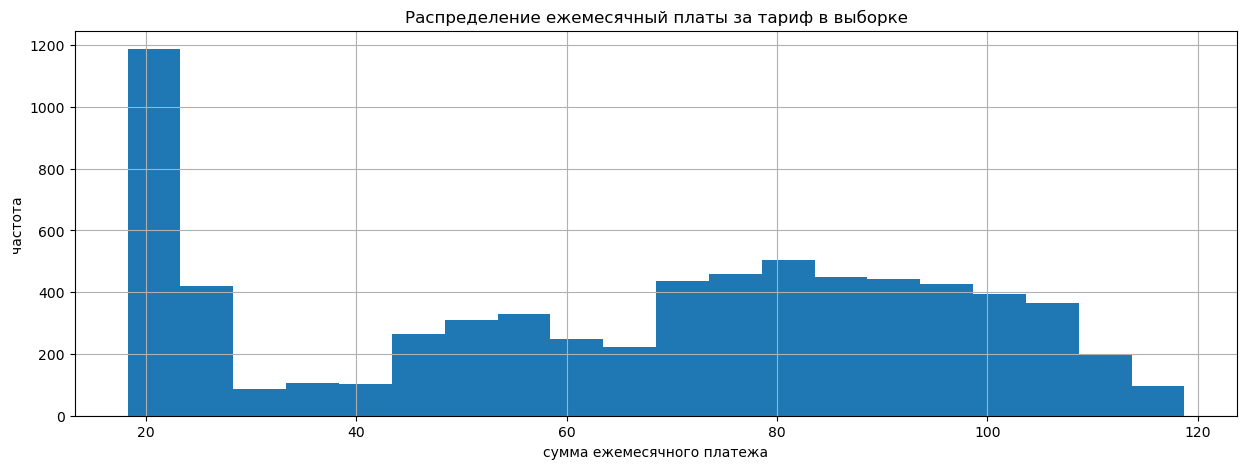

In [14]:
(contract['MonthlyCharges'].plot(kind = 'hist', bins=20, grid=True, figsize=(15,5))
  .set(title = 'Распределение ежемесячный платы за тариф в выборке', xlabel = 'сумма ежемесячного платежа', ylabel = 'частота'));

Учитывая распределение, можно заключить, что клиенты условно делятся на 2 группы:\
    1) ежемесячная плата меньше 30, скорее всего эти клиенты берут самое дешевое подключение без каких либо услуг.\
    2) клиенты с ежемесячной платой больше 30, берут услуги компании в разном количестве.\
    
Это можно выделить как признак и проставить первой группе 0, а второй 1 - рассматривать признак как качественный признак.

Приблизим данные суммы, которые близки с нулю:

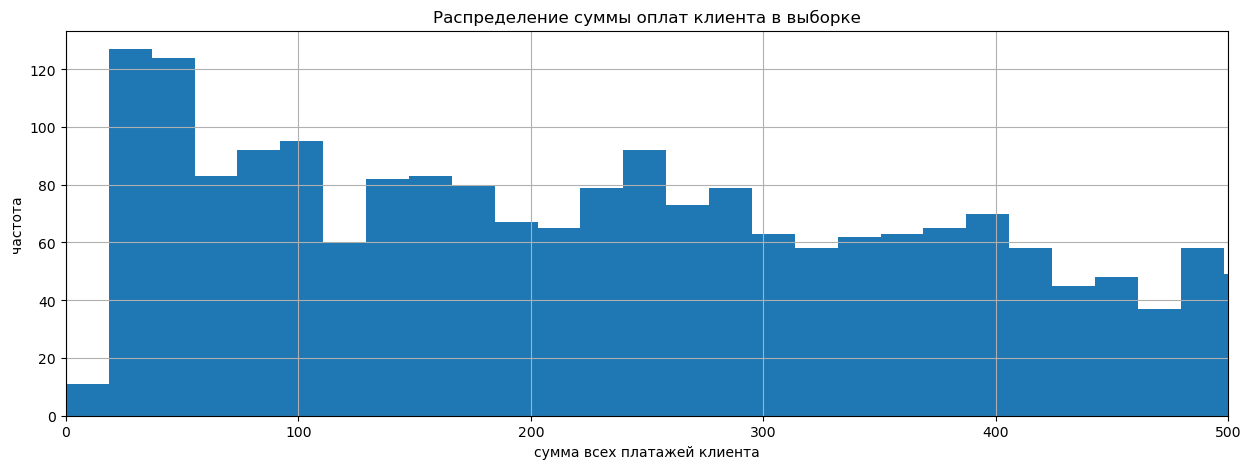

In [15]:
(contract['TotalCharges'].plot(kind = 'hist', bins=500, grid=True, figsize=(15,5), xlim=(0, 500))
  .set(title = 'Распределение суммы оплат клиента в выборке', xlabel = 'сумма всех платажей клиента', ylabel = 'частота'));

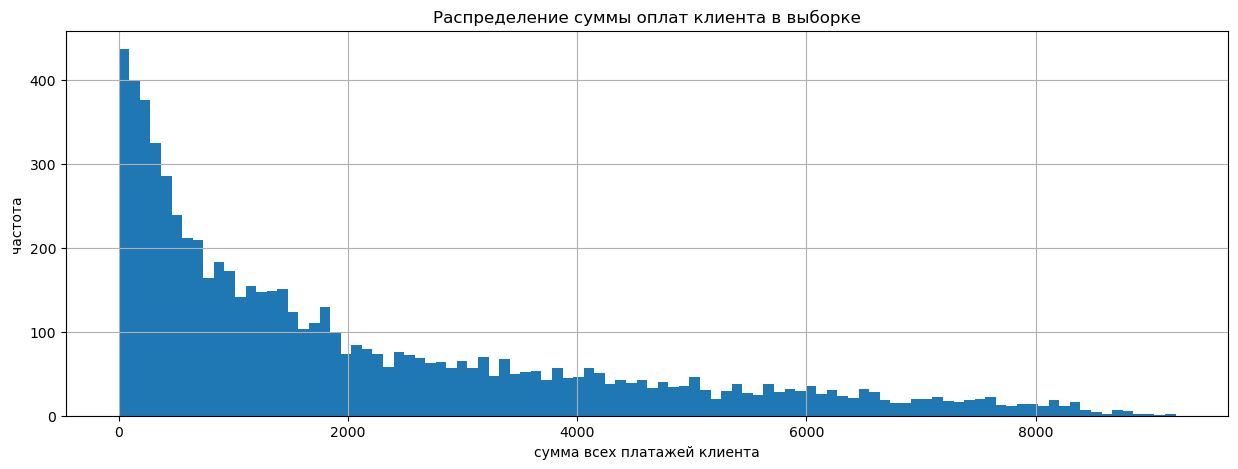

In [16]:
(contract['TotalCharges'].plot(kind = 'hist', bins=100, grid=True, figsize=(15,5))
  .set(title = 'Распределение суммы оплат клиента в выборке', xlabel = 'сумма всех платажей клиента', ylabel = 'частота'));

По распределнию суммарной оплаты заключить ничего не могу, считаю что нужно рассмореть распределение новых созданных признаков.

**Выводы по датасеты данных о договорах:**

1) столбец customerID будет удален из признаков после объединения таблиц в датасет для обучения. Он неинформативен

2) Отсутствует целевой признак ухода клиента, необходимо его создать

3) Необходимо создать дополнительный признак по количеству дней работы с этим клиентом

4) Нужно создать новый дополнительный признак разности идеальной суммы платежей. Тогда будет понятно насколько много платежей клиент припускает, что как раз может являться предзнаменованием его ухода.

5) Выделить новый признак принадлежности клиента группе с минимальной ежемесячной оплатой или нет

### Данные о клиентах

In [17]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [18]:
for column in personal.columns:
    print(column, personal[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


In [19]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


По сути, SeniorCitizen - качественный признак. Меняем тип данных:

In [20]:
personal['SeniorCitizen']=personal['SeniorCitizen'].astype('str')

In [21]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [22]:
personal.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


        customerID         %
gender                      
Female        3488  49.52435
Male          3555  50.47565


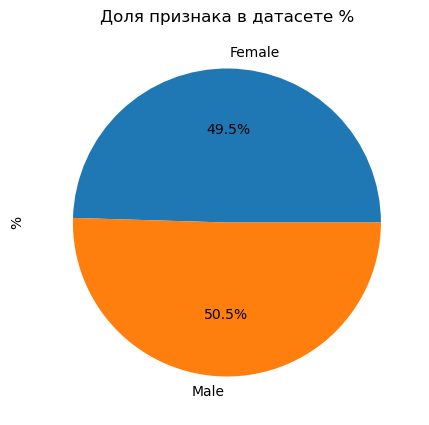

               customerID          %
SeniorCitizen                       
0                    5901  83.785319
1                    1142  16.214681


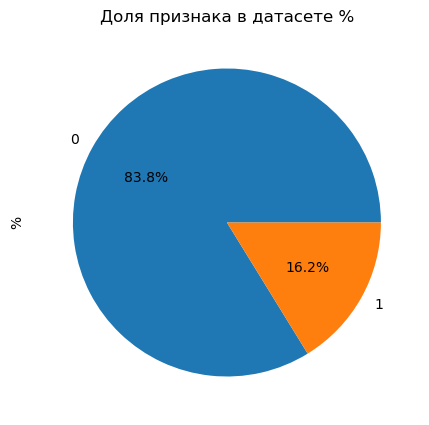

         customerID         %
Partner                      
No             3641  51.69672
Yes            3402  48.30328


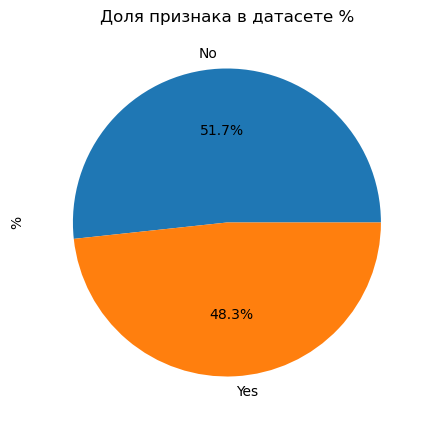

            customerID          %
Dependents                       
No                4933  70.041176
Yes               2110  29.958824


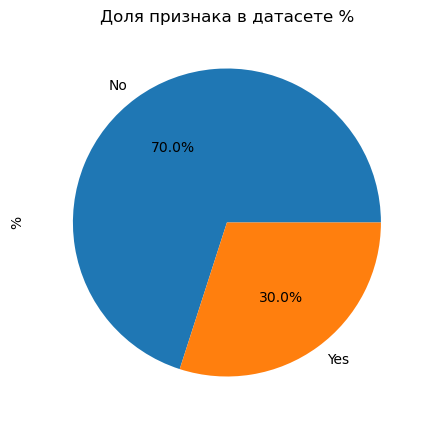

In [23]:
for personal_column in personal.columns:
    if personal_column != 'customerID':
        column_data = personal.pivot_table(index = personal_column, values = 'customerID', aggfunc='count')
        column_data['%'] = ((column_data['customerID'])/(sum(column_data['customerID']))*100)
        print(column_data)
        column_data['%'].plot(kind='pie', autopct='%1.1f%%', figsize=(10,5)).set(title = 'Доля признака в датасете %')
        plt.show();

**Выводы по данным личной информации о клиентах:**

1) Мужчин и женщин в датасете примерно поровну.\
2) Около 16% пенсионеры.\
3) У половины клиентов есть семья.\
4) У 30% клиентов есть дети.

### Данные об услугах

In [24]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [25]:
for column in internet.columns:
    print(column, internet[column].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']


In [26]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [27]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


                 customerID          %
InternetService                       
DSL                    2421  43.882545
Fiber optic            3096  56.117455


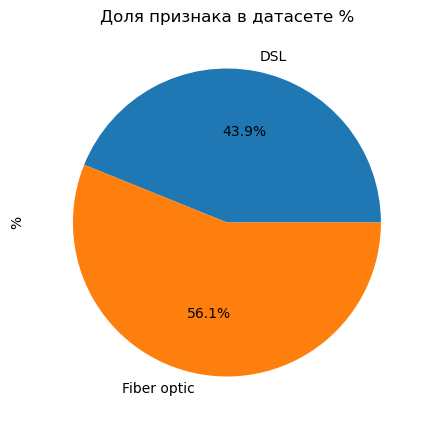

                customerID          %
OnlineSecurity                       
No                    3498  63.404024
Yes                   2019  36.595976


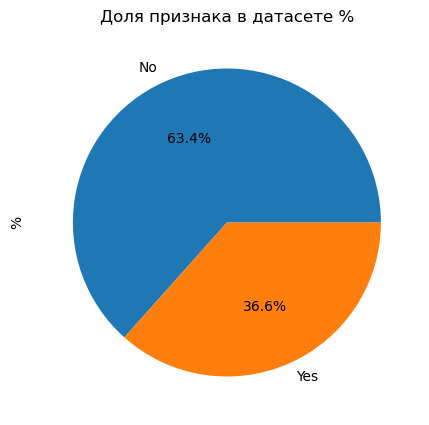

              customerID          %
OnlineBackup                       
No                  3088  55.972449
Yes                 2429  44.027551


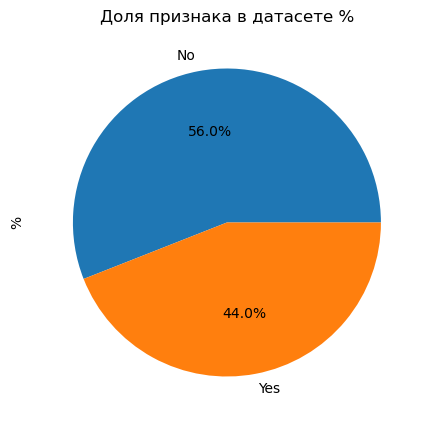

                  customerID          %
DeviceProtection                       
No                      3095  56.099329
Yes                     2422  43.900671


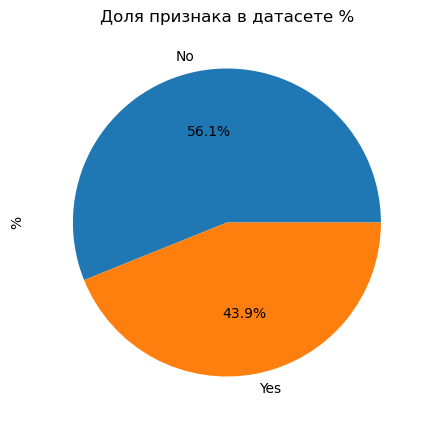

             customerID          %
TechSupport                       
No                 3473  62.950879
Yes                2044  37.049121


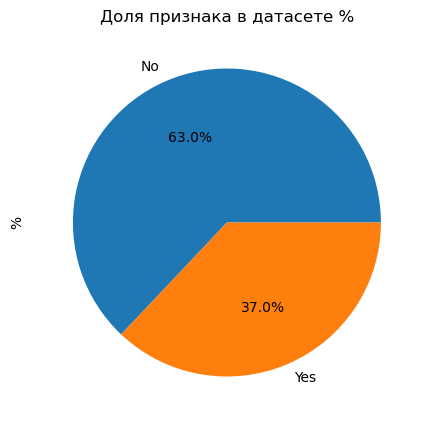

             customerID          %
StreamingTV                       
No                 2810  50.933478
Yes                2707  49.066522


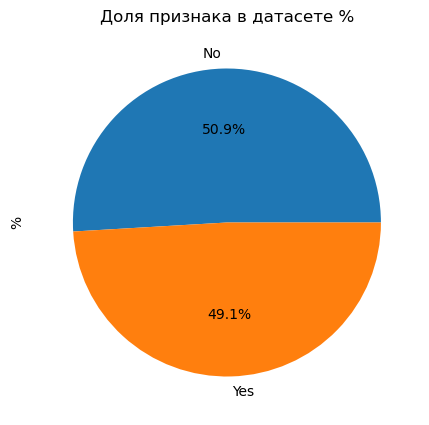

                 customerID          %
StreamingMovies                       
No                     2785  50.480334
Yes                    2732  49.519666


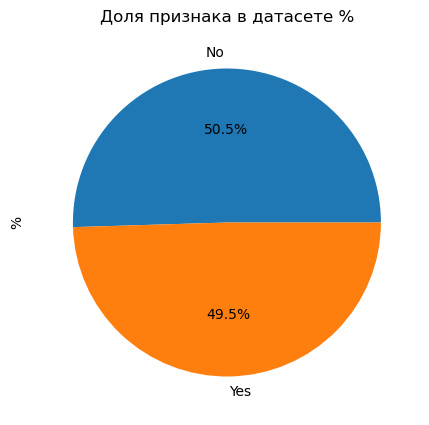

In [28]:
for internet_column in internet.columns:
    if internet_column != 'customerID':
        column_data = internet.pivot_table(index = internet_column, values = 'customerID', aggfunc='count')
        column_data['%'] = ((column_data['customerID'])/(sum(column_data['customerID']))*100)
        print(column_data)
        column_data['%'].plot(kind='pie', autopct='%1.1f%%', figsize=(10,5)).set(title = 'Доля признака в датасете %')
        plt.show();

**Выводы о данных по услугам:**

1) через телефонную линию интернетом пользуются около 44% клиентов, остальные через оптоволоконный кабель.\
2) блокировкой вредных сайтов пользуются 36% клиентов.\
3) услугой резервного копирования данных пользуются 44% клиентов.\
4) антивирусом пользуются 44% клиентов.\
5) услугу технической поддержки подключили себе 37% клиентов.\
6) услугой стримингового телевидения пользуются 50% клиентов.\
7) стриминговую библиотеку подключили себе 50% клиентов.

### Данные об использовании телефонии

In [29]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [30]:
for column in phone.columns:
    print(column, phone[column].unique())

customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
MultipleLines ['No' 'Yes']


In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [32]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


               customerID          %
MultipleLines                       
No                   3390  53.293507
Yes                  2971  46.706493


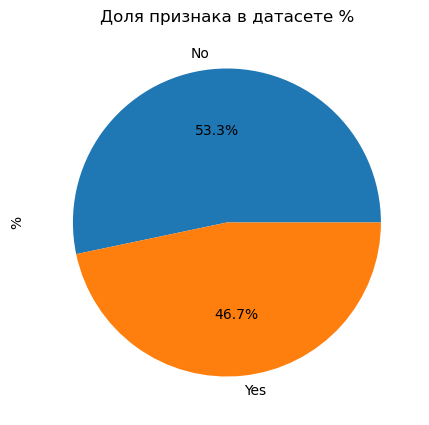

In [33]:
for phone_column in phone.columns:
    if phone_column != 'customerID':
        column_data = phone.pivot_table(index = phone_column, values = 'customerID', aggfunc='count')
        column_data['%'] = ((column_data['customerID'])/(sum(column_data['customerID']))*100)
        print(column_data)
        column_data['%'].plot(kind='pie', autopct='%1.1f%%', figsize=(10,5)).set(title = 'Доля признака в датасете %')
        plt.show();

**Выводы по данным использования телефонии:**

48% клиентов пользуются услугой телефонии. Этот признак оставляем для обучения модели.

### Объединение таблиц

In [34]:
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [35]:
data['Client_leaving'] = data['EndDate'] != 'No'
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False


                customerID          %
Client_leaving                       
False                 5942  84.367457
True                  1101  15.632543


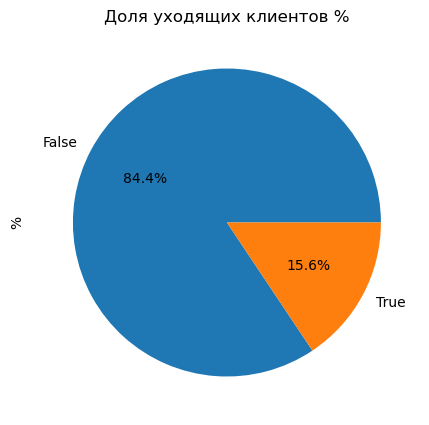

In [36]:
column_data = data.pivot_table(index = 'Client_leaving', values = 'customerID', aggfunc='count')
column_data['%'] = ((column_data['customerID'])/(sum(column_data['customerID']))*100)
print(column_data)
column_data['%'].plot(kind='pie', autopct='%1.1f%%', figsize=(10,5)).set(title = 'Доля уходящих клиентов %')
plt.show();

## Cоздание новых признаков

### Список

1) Выделить новый признак принадлежности клиента группе с минимальной ежемесячной оплатой или нет

2) Отсутствует целевой признак ухода клиента, необходимо его создать

3) Необходимо создать дополнительный признак по количеству дней работы с этим клиентом

4) Нужно создать новый дополнительный признак разности идеальной суммы платежей. Тогда будет понятно насколько много платежей клиент припускает, что как раз может являться предзнаменованием его ухода.

5) столбец customerID будет удален из признаков после объединения таблиц в датасет для обучения. Он неинформативен

In [37]:
data['Min_pay_client'] = data['MonthlyCharges'] < 30
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False


In [38]:
data['date_of_end'] = 0
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,date_of_end
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,0


In [39]:
data.loc[data['EndDate'] == 'No', 'date_of_end'] = '2020-02-01'
data.loc[data['EndDate'] != 'No', 'date_of_end'] = data['EndDate']
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,date_of_end
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True,2020-02-01
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,2020-02-01
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,2020-02-01
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False,2020-02-01
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,2020-02-01


In [40]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%dT')
data['date_of_end'] = pd.to_datetime(data['date_of_end'], format='%Y-%m-%dT')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [41]:
data['Days_of_work'] = (data['date_of_end'] - data['BeginDate']).dt.days
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,date_of_end,Days_of_work
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,2020-02-01,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,2020-02-01,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False,2020-02-01,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,2020-02-01,153


In [42]:
data['Sum_of_delay'] = data['TotalCharges'] - (round(data['Days_of_work']/30, 0)*data['MonthlyCharges'])
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,date_of_end,Days_of_work,Sum_of_delay
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True,2020-02-01,31,1.19
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,2020-02-01,1036,78.59
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,2020-02-01,123,10.77
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False,2020-02-01,1371,14.80
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,2020-02-01,153,0.00


### Проверка на дубликаты

In [43]:
# проверка на полные дубликаты
print(data.duplicated().sum())

0


In [44]:
# проверка на дубликаты по ID клиента
print(data['customerID'].duplicated().sum())

0


Дубликатов в датасете нет, можно приступать к удалению неинформативных признаков:

Убираем столбцы, которые не нужны для обучения (рабочие-вычислительные и неинформативные для модели):

In [45]:
columns_for_drop = ['customerID', 'BeginDate', 'EndDate', 'TotalCharges', 'date_of_end']
data = data.drop(columns = columns_for_drop, axis = 1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,Days_of_work,Sum_of_delay
0,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,False,True,31,1.19
1,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,1036,78.59
2,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,123,10.77
3,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,False,False,1371,14.80
4,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,153,0.00


### Работа с пропусками

Проверим образовались ли какие-либо пропуски:

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   gender            7043 non-null   object 
 5   SeniorCitizen     7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  MultipleLines     6361 non-null   object 
 16  Client_leaving    7043 non-null   bool   


In [47]:
data = data.fillna('No')

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   gender            7043 non-null   object 
 5   SeniorCitizen     7043 non-null   object 
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  Client_leaving    7043 non-null   bool   


In [49]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,Days_of_work,Sum_of_delay
0,Month-to-month,Yes,Electronic check,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,False,True,31,1.19
1,One year,No,Mailed check,56.95,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,1036,78.59
2,Month-to-month,Yes,Mailed check,53.85,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,123,10.77
3,One year,No,Bank transfer (automatic),42.30,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,False,False,1371,14.80
4,Month-to-month,Yes,Electronic check,70.70,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,153,0.00


Запишем качественные и количественные признаки в два списка для удобства:

In [50]:
# создаем список количественных и качественных признаков:
numeric=[]
category = []
for col in data.columns:
    if data[col].dtype != 'object':
        if (data[col].dtype != 'bool'):
            numeric.append(col)
        else:
            category.append(col)
    else:
        category.append(col)
        
print(numeric)
print(len(numeric))
print(category)
print(len(category))

['MonthlyCharges', 'Days_of_work', 'Sum_of_delay']
3
['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Client_leaving', 'Min_pay_client']
17


Итого: 16 качественных и 3 количественных признака + один целевой признак

### Проверка на мультиколлинеарность

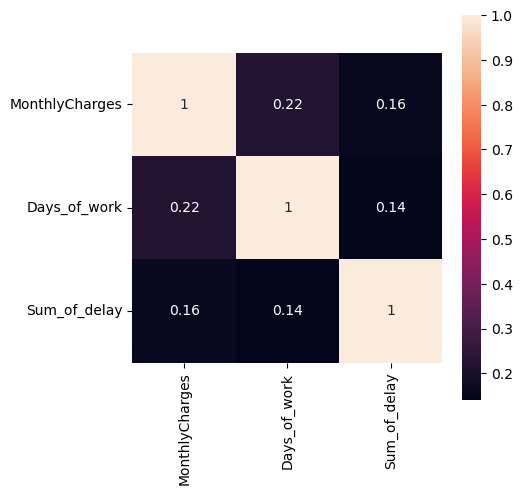

In [51]:
multi = data[numeric].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(multi, annot=True, square=True);

Количественные признаки между собой линейно коррелируют слабо. Это хороший знак.

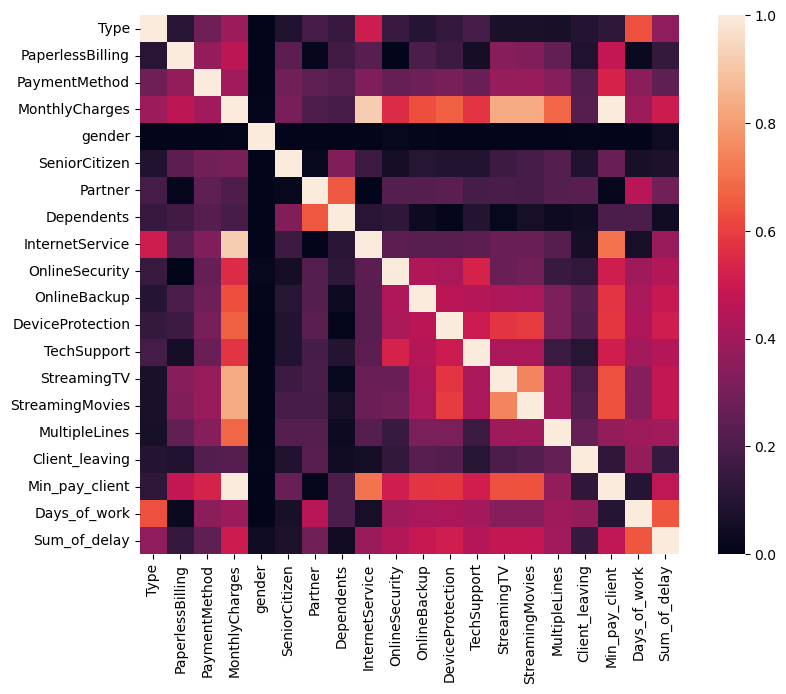

In [52]:
multi_all = data.phik_matrix (numeric)
plt.figure(figsize=(10, 7))
sns.heatmap(multi_all, square=True);

По тепловой карте корреляций количественных и качественных признаков, а также их корреляции с целевым признаков можно сделать вывод, что признак gender (пол клиента), не коррелирует ни с целевым, ни с остальными признаками, на этом основании его можно исключить из обучения моделей:

In [53]:
data = data.drop(columns = 'gender', axis = 1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Client_leaving,Min_pay_client,Days_of_work,Sum_of_delay
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,No,False,True,31,1.19
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,False,1036,78.59
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,No,False,False,123,10.77
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,False,False,1371,14.80
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,False,153,0.00


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   SeniorCitizen     7043 non-null   object 
 5   Partner           7043 non-null   object 
 6   Dependents        7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  MultipleLines     7043 non-null   object 
 15  Client_leaving    7043 non-null   bool   
 16  Min_pay_client    7043 non-null   bool   


**Итого: 15 качественных и 3 количественных прихнака + один целевой признак**

## Моделирование

### Разбиваем данные на выборки

In [55]:
# змеиный стиль столбцов в студию
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines', 'client_leaving',
       'min_pay_client', 'days_of_work', 'sum_of_delay'],
      dtype='object')

In [56]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('client_leaving', axis=1), data.client_leaving, test_size=TEST_SIZE, random_state=RANDOM_STATE, \
    stratify=data.client_leaving) 

In [57]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [58]:
# создаем список количественных и качественных признаков:
numeric=[]
category = []
for col in features_train.columns:
    if features_train[col].dtype != 'object':
        if (features_train[col].dtype != 'bool'):
            numeric.append(col)
        else:
            category.append(col)
    else:
        category.append(col)
        
print(numeric)
print(len(numeric))
print(category)
print(len(category))

['monthly_charges', 'days_of_work', 'sum_of_delay']
3
['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines', 'min_pay_client']
15


### Логическая регрессия (пайплайн)

In [59]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop='first', sparse='False'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, category)
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [60]:
%%time
scores =  cross_validate(model, features_train, target_train, scoring = 'roc_auc', cv=3, verbose = 3)

[CV] END ......................................., score=0.781 total time=   0.0s
[CV] END ......................................., score=0.709 total time=   0.0s
[CV] END ......................................., score=0.753 total time=   0.0s
Wall time: 135 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [61]:
print(model.score)
print(scores)
print('Значение метрики roc_auc:', scores['test_score'].mean())
print('Время обучения:', scores['fit_time'].sum())
print('Время предсказания:', scores['score_time'].sum());

<function Pipeline.score at 0x0000017C80641820>
{'fit_time': array([0.03600788, 0.03200698, 0.02900696]), 'score_time': array([0.01000261, 0.0100019 , 0.01000261]), 'test_score': array([0.78072923, 0.70864686, 0.75292807])}
Значение метрики roc_auc: 0.7474347179936185
Время обучения: 0.09702181816101074
Время предсказания: 0.030007123947143555


### Случайный лес (пайплайн)

In [62]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, category)
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=RANDOM_STATE))]
)

In [63]:
%%time

parametrs = { 'classifier__n_estimators': [50, 100, 200, 400],  # число деревьев в лесу  
              'classifier__max_depth': [5, 10, 15],             # глубина дерева        
              'classifier__min_samples_leaf': range (1, 5),     # минимальное число образцов в листах
              'classifier__min_samples_split': range (2,11,2)}  # минимальное число образцов для сплита

grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'roc_auc', verbose=3)
grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print(grid.best_score_)   # выводим лучшее значение метрики 
table_of_results = pd.DataFrame(grid.cv_results_) # выводит очень полезную табличку со всеми данными по обучению и метрикам
print('Суммарное время обучения (с подбором параметров):', table_of_results['mean_fit_time'].sum())
print('Суммарное время предсказания (с подбором параметров):', table_of_results['mean_score_time'].sum())
table_of_results

Fitting 3 folds for each of 240 candidates, totalling 720 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 400}
0.827077628428725
Суммарное время обучения (с подбором параметров): 194.90201115608215
Суммарное время предсказания (с подбором параметров): 18.71847716967265
Wall time: 43.6 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.198375,0.006130,0.029340,0.001699,5,1,2,50,"{'classifier__max_depth': 5, 'classifier__min_...",0.833564,0.791134,0.820238,0.814978,0.017717,231
1,0.374417,0.023801,0.044343,0.003400,5,1,2,100,"{'classifier__max_depth': 5, 'classifier__min_...",0.833948,0.792876,0.817211,0.814678,0.016863,235
2,0.708824,0.037069,0.073350,0.010659,5,1,2,200,"{'classifier__max_depth': 5, 'classifier__min_...",0.834738,0.794088,0.818978,0.815934,0.016734,219
3,1.359174,0.056418,0.136696,0.023800,5,1,2,400,"{'classifier__max_depth': 5, 'classifier__min_...",0.834926,0.794603,0.818890,0.816140,0.016576,215
4,0.184708,0.004110,0.030341,0.001248,5,1,4,50,"{'classifier__max_depth': 5, 'classifier__min_...",0.835169,0.792929,0.820787,0.816295,0.017535,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.593417,0.068763,0.108024,0.002450,15,4,8,400,"{'classifier__max_depth': 15, 'classifier__min...",0.842858,0.801488,0.821517,0.821954,0.016892,72
236,0.251723,0.014617,0.035342,0.003859,15,4,10,50,"{'classifier__max_depth': 15, 'classifier__min...",0.838702,0.797233,0.819433,0.818456,0.016944,130
237,0.526844,0.033444,0.052345,0.000471,15,4,10,100,"{'classifier__max_depth': 15, 'classifier__min...",0.840849,0.799029,0.818231,0.819370,0.017092,121
238,0.820576,0.033337,0.067349,0.001247,15,4,10,200,"{'classifier__max_depth': 15, 'classifier__min...",0.845496,0.801261,0.819891,0.822216,0.018133,70


### Бустинг  **CatBoostClassifier**

Масштабирование для количественных признаков:

In [64]:
scaler = StandardScaler() 
# используем ранее созданный список с количественными признаками
scaler.fit(features_train[numeric])

features_train[numeric] =scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head() # проверка визуально

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,min_pay_client,days_of_work,sum_of_delay
6026,Month-to-month,No,Credit card (automatic),-1.505935,0,No,No,No,No,No,No,No,No,No,No,True,-0.739561,-0.206871
2361,Month-to-month,No,Mailed check,-0.626357,0,No,Yes,DSL,No,No,No,No,No,No,No,False,-1.225403,-0.281221
3293,Month-to-month,Yes,Electronic check,-0.027249,0,No,No,DSL,No,Yes,No,No,No,Yes,Yes,False,-1.093033,-0.281221
6491,Month-to-month,Yes,Electronic check,0.145347,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,-1.093033,-0.010074
2802,Month-to-month,Yes,Electronic check,1.330287,1,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,False,-0.825384,-0.281221


In [65]:
features_train.head() # просто для справки выводим

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,min_pay_client,days_of_work,sum_of_delay
6026,Month-to-month,No,Credit card (automatic),-1.505935,0,No,No,No,No,No,No,No,No,No,No,True,-0.739561,-0.206871
2361,Month-to-month,No,Mailed check,-0.626357,0,No,Yes,DSL,No,No,No,No,No,No,No,False,-1.225403,-0.281221
3293,Month-to-month,Yes,Electronic check,-0.027249,0,No,No,DSL,No,Yes,No,No,No,Yes,Yes,False,-1.093033,-0.281221
6491,Month-to-month,Yes,Electronic check,0.145347,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,-1.093033,-0.010074
2802,Month-to-month,Yes,Electronic check,1.330287,1,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,False,-0.825384,-0.281221


In [66]:
%%time

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=10) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [200, 400],        # число деревьев в лесу   
              'max_depth': [2, 3, 4, 5, 7],      # потому что бустинговые модели лучше работают на ПЕНЬКАХ
               'learning_rate': [0.1, 0.3, 0.5]} # learning_rate - скорость обучения (от 0 до 1)
              
grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'roc_auc', verbose=3)   # запускаем обучение

grid.fit(features_train, target_train, cat_features=category)


print(grid.best_params_)   # выводим результат лучших параметров
print(grid.best_score_)   # выводим лучшее значение метрики 
table_of_results = pd.DataFrame(grid.cv_results_)
print()
print('Суммарное время обучения (с подбором параметров):', table_of_results['mean_fit_time'].sum())
print('Суммарное время предсказания (с подбором параметров):', table_of_results['mean_score_time'].sum())
table_of_results

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 0.4795180	total: 159ms	remaining: 1m 3s
10:	learn: 0.3353693	total: 334ms	remaining: 11.8s
20:	learn: 0.3249873	total: 538ms	remaining: 9.72s
30:	learn: 0.3173822	total: 701ms	remaining: 8.35s
40:	learn: 0.3022243	total: 873ms	remaining: 7.64s
50:	learn: 0.2906497	total: 1.07s	remaining: 7.32s
60:	learn: 0.2762470	total: 1.23s	remaining: 6.82s
70:	learn: 0.2584702	total: 1.4s	remaining: 6.5s
80:	learn: 0.2510621	total: 1.6s	remaining: 6.31s
90:	learn: 0.2418083	total: 1.75s	remaining: 5.96s
100:	learn: 0.2338060	total: 1.96s	remaining: 5.81s
110:	learn: 0.2255633	total: 2.12s	remaining: 5.52s
120:	learn: 0.2168915	total: 2.28s	remaining: 5.25s
130:	learn: 0.2124967	total: 2.46s	remaining: 5.04s
140:	learn: 0.2053778	total: 2.6s	remaining: 4.78s
150:	learn: 0.1980428	total: 2.77s	remaining: 4.57s
160:	learn: 0.1949512	total: 2.99s	remaining: 4.44s
170:	learn: 0.1908137	total: 3.17s	remaining: 4.25s
180:	learn: 0.1879

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.701674,0.123684,0.057346,0.003300,0.1,2,200,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.858641,0.817611,0.837799,0.838017,0.016751,30
1,13.746320,0.547442,0.077361,0.013897,0.1,2,400,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.868812,0.826692,0.858545,0.851350,0.017932,28
2,8.630609,0.244937,0.060680,0.004498,0.1,3,200,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.871785,0.819719,0.849410,0.846972,0.021326,29
3,18.489380,1.006335,0.105690,0.032177,0.1,3,400,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.887612,0.851127,0.876124,0.871621,0.015231,22
4,10.882296,0.234894,0.064681,0.011560,0.1,4,200,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.877975,0.841307,0.856466,0.858583,0.015044,27
5,23.915064,0.248319,0.065683,0.008500,0.1,4,400,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.896982,0.871322,0.888284,0.885529,0.010655,17
6,14.494403,0.065715,0.062684,0.007935,0.1,5,200,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.880395,0.844383,0.874252,0.866343,0.015729,25
7,28.907930,0.393454,0.076017,0.015300,0.1,5,400,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.897172,0.874496,0.902736,0.891468,0.012214,12
8,19.777935,0.243571,0.055345,0.002868,0.1,7,200,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.880045,0.837698,0.878269,0.865337,0.019557,26
9,38.064870,0.269955,0.098689,0.004498,0.1,7,400,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.890959,0.861653,0.888475,0.880362,0.013268,18


### Бустинг  **LightGBMClassifier**

In [67]:
features_train.head() # просто для справки выводим

,type,paperless_billing,payment_method,monthly_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,min_pay_client,days_of_work,sum_of_delay
6026,Month-to-month,No,Credit card (automatic),-1.505935,0,No,No,No,No,No,No,No,No,No,No,True,-0.739561,-0.206871
2361,Month-to-month,No,Mailed check,-0.626357,0,No,Yes,DSL,No,No,No,No,No,No,No,False,-1.225403,-0.281221
3293,Month-to-month,Yes,Electronic check,-0.027249,0,No,No,DSL,No,Yes,No,No,No,Yes,Yes,False,-1.093033,-0.281221
6491,Month-to-month,Yes,Electronic check,0.145347,0,No,No,Fiber optic,No,No,No,No,No,No,No,False,-1.093033,-0.010074
2802,Month-to-month,Yes,Electronic check,1.330287,1,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,False,-0.825384,-0.281221


In [68]:
features_train[category] = features_train[category].astype('category') # для LightGBMRegressor требуется, присвоит тип данных 
                                                                       # 'category', чтобы он распознал категориальные данные
features_test[category] = features_test[category].astype('category')

In [69]:
features_train.info() # для проверки результата выводим

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6026 to 636
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   senior_citizen     5282 non-null   category
 5   partner            5282 non-null   category
 6   dependents         5282 non-null   category
 7   internet_service   5282 non-null   category
 8   online_security    5282 non-null   category
 9   online_backup      5282 non-null   category
 10  device_protection  5282 non-null   category
 11  tech_support       5282 non-null   category
 12  streaming_t_v      5282 non-null   category
 13  streaming_movies   5282 non-null   category
 14  multiple_lines     5282 non-null   category
 15  min_pay_client     5282 non-null   category
 16  days

In [70]:
%%time
model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=10) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [100, 200, 400],   # число деревьев в лесу   
              'max_depth': [3, 5, 7],            # глубина дерева        
               'learning_rate': [0.3],           # learning_rate - скорость обучения (от 0 до 1)
               'force_col_wise': [True],   
               'num_leaves' : [129],       # Чтобы дерево гарантированно достигало глубины нужно num_leaves сделать
                'num_threads':[1]}         # равным 2^max_depth.  Но не факт, что это улучшит работу модели и может 
                                           # только утяжелить модель. Можно попробовать разные варианты:                        
                                           # дефолтное значение 31, какое-нибудь среднее значение, и 2^10 например.                      
grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'roc_auc', verbose=2) # запускаем обучение

grid.fit(features_train, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print(grid.best_score_)   # выводим лучшее значение метрики 
table_of_results = pd.DataFrame(grid.cv_results_)
print()
print('Суммарное время обучения (с подбором параметров):', table_of_results['mean_fit_time'].sum())
print('Суммарное время предсказания (с подбором параметров):', table_of_results['mean_score_time'].sum())
table_of_results

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.696003
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Tr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_force_col_wise,param_learning_rate,param_max_depth,param_n_estimators,param_num_leaves,param_num_threads,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.310403,0.020160,0.012336,0.001248,True,0.3,3,100,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.885083,0.838786,0.871699,0.865189,0.019453,8
1,0.527786,0.025005,0.026341,0.001884,True,0.3,3,200,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.893100,0.859845,0.890635,0.881193,0.015129,2
2,0.650143,0.063986,0.042677,0.001247,True,0.3,3,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.895366,0.867818,0.896872,0.886685,0.013355,1
3,0.439098,0.013143,0.020670,0.003771,True,0.3,5,100,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.887974,0.855399,0.879035,0.874136,0.013742,5
4,0.514115,0.042771,0.036675,0.001701,True,0.3,5,200,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.887612,0.859874,0.883083,0.876856,0.012150,3
5,0.601134,0.063486,0.048011,0.003560,True,0.3,5,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.885931,0.859130,0.879393,0.874818,0.011410,4
6,0.238053,0.026552,0.027007,0.002829,True,0.3,7,100,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.862793,0.850427,0.880781,0.864667,0.012463,9
7,0.302741,0.014620,0.039002,0.002446,True,0.3,7,200,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.874072,0.856461,0.883387,0.871306,0.011165,7
8,0.456435,0.023233,0.057679,0.000471,True,0.3,7,400,129,1,"{'force_col_wise': True, 'learning_rate': 0.3,...",0.873974,0.861199,0.882143,0.872439,0.008619,6


### Бустинг  **XGBoost**

**Кодирование OHE**

**Используем OneHotEncoder() для кодирования качественных признаков данных**

In [71]:
encoder_ohe = OneHotEncoder(drop='first', sparse='False') 
# handle_unknown='ignore'
# drop='first' удаляет первый признак из закодированных, таким образом обходим dummy-ловушку
# Если указать drop='if_binary',  то будет отброшена категория только для бинарных признаков.
# задаём handle_unknown='ignore': игнорируется ранее невстречающиеся значения признака (при transform)
# sparse='False' - чтобы не возвращалась "разреженная" матрица.

features_train_ohe = features_train.copy() #создаем копию, на всякий случай

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[category])
encoder_columns = list(encoder_ohe.get_feature_names()) #encoder_ohe.get_feature_names_out() позволяет получить названия колонок

# добавляем закодированные признаки в features_train
features_train_ohe[encoder_columns]  = pd.DataFrame(encoder_ohe.transform(features_train_ohe[category]).toarray(),\
                                                index = features_train_ohe.index,  columns= encoder_columns)   

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(category, axis=1)


# Та же процедура для тестовой выборки:
features_test_ohe = features_test.copy()

# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую выборку
features_test_ohe[encoder_columns] = pd.DataFrame(encoder_ohe.transform(features_test_ohe[category]).toarray(),\
                                                  index = features_test_ohe.index,  columns= encoder_columns) 
features_test_ohe = features_test_ohe.drop(category, axis=1)


features_train_ohe.head() # визуализация

,monthly_charges,days_of_work,sum_of_delay,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_1,x4_Yes,x5_Yes,x6_Fiber optic,x6_No,x7_Yes,x8_Yes,x9_Yes,x10_Yes,x11_Yes,x12_Yes,x13_Yes,x14_True
6026,-1.505935,-0.739561,-0.206871,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2361,-0.626357,-1.225403,-0.281221,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3293,-0.027249,-1.093033,-0.281221,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
6491,0.145347,-1.093033,-0.010074,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2802,1.330287,-0.825384,-0.281221,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0


In [72]:
%%time
# нужно преобразовать данные в определенный формат, который может обрабатывать XGBoost. Этот формат называетсяDMatrix
D_train = xgb.DMatrix(features_train_ohe, label=target_train, enable_categorical=True)
D_test = xgb.DMatrix(features_test_ohe, label=target_test, enable_categorical=True)

clf = xgb.XGBClassifier(random_state=RANDOM_STATE) # enable_categorical=True - чтобы модель принимала данные типа category

parameters = {
     'n_estimators': [400],                 # число деревьев в лесу   
     'eta' : [0.3],                         # learning rate - скорость обучения (псевдоним:eta)
     'max_depth' : [ 3, 5, 7]               # глубина дерева        
      }

grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring="roc_auc", cv=3, verbose=2) # запускаем обучение

grid.fit(features_train_ohe, target_train)

print(grid.best_params_)   # выводим результат лучших параметров
print(grid.best_score_)   # выводим лучшее значение метрики 
table_of_results = pd.DataFrame(grid.cv_results_)
print()
print('Суммарное время обучения (с подбором параметров):', table_of_results['mean_fit_time'].sum())
print('Суммарное время предсказания (с подбором параметров):', table_of_results['mean_score_time'].sum())
table_of_results

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'eta': 0.3, 'max_depth': 3, 'n_estimators': 400}
0.9026194515996782

Суммарное время обучения (с подбором параметров): 0.9113051096598308
Суммарное время предсказания (с подбором параметров): 0.05067817370096843
Wall time: 683 ms


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.230397,0.005353,0.013003,8.173135e-04,0.3,3,400,"{'eta': 0.3, 'max_depth': 3, 'n_estimators': 400}",0.904572,0.892988,0.910298,0.902619,0.007201,1
1,0.311731,0.010039,0.016003,1.123916e-07,0.3,5,400,"{'eta': 0.3, 'max_depth': 5, 'n_estimators': 400}",0.884440,0.877712,0.894149,0.885434,0.006747,2
2,0.369177,0.006343,0.021671,4.724943e-04,0.3,7,400,"{'eta': 0.3, 'max_depth': 7, 'n_estimators': 400}",0.877654,0.859747,0.884077,0.873826,0.010295,3


### Итоги работы моделей:

In [73]:
models = {
    "Model": [
        "Логическая регрессия",
        "Случайный лес",
        "Бустинг CatBoost",
        "LightGBMClassifier",
        "XGBoost",
    ],
    "Лучший показатель метрики roc_auc": [0.75, 0.83, 0.91, 0.89, 0.90],
 
}

df = pd.DataFrame(models)
display(df)

,Model,Лучший показатель метрики roc_auc
0,Логическая регрессия,0.75
1,Случайный лес,0.83
2,Бустинг CatBoost,0.91
3,LightGBMClassifier,0.89
4,XGBoost,0.90


**Исходя из данных лучшая модель это :  Бустинг CatBoost**

**Ее гиперпараметры: , 2 - глубина дерева, 400 - количество деревьев, learning_rate - 0.5** 

## Тестирование самой успешной модели

In [74]:
%%time

model = CatBoostClassifier(custom_loss = 'AUC', iterations= 400, depth = 2, learning_rate = 0.5, random_state=RANDOM_STATE, verbose=10) 

model.fit(features_train, target_train, verbose=20, cat_features=category) 

predictions_proba = model.predict_proba(features_test) # Получим предсказания модели

print('Значение Catboost метрики roc_auc:', roc_auc_score(target_test, predictions_proba[:, 1]))

0:	learn: 0.4795180	total: 14.1ms	remaining: 5.63s
20:	learn: 0.3249873	total: 414ms	remaining: 7.46s
40:	learn: 0.3022243	total: 845ms	remaining: 7.4s
60:	learn: 0.2762470	total: 1.19s	remaining: 6.63s
80:	learn: 0.2510621	total: 1.53s	remaining: 6.01s
100:	learn: 0.2338060	total: 1.91s	remaining: 5.66s
120:	learn: 0.2168915	total: 2.25s	remaining: 5.19s
140:	learn: 0.2053778	total: 2.56s	remaining: 4.71s
160:	learn: 0.1949512	total: 2.96s	remaining: 4.39s
180:	learn: 0.1879849	total: 3.35s	remaining: 4.06s
200:	learn: 0.1805249	total: 3.73s	remaining: 3.7s
220:	learn: 0.1756388	total: 4.25s	remaining: 3.44s
240:	learn: 0.1666857	total: 4.6s	remaining: 3.04s
260:	learn: 0.1601756	total: 4.94s	remaining: 2.63s
280:	learn: 0.1542429	total: 5.29s	remaining: 2.24s
300:	learn: 0.1492849	total: 5.67s	remaining: 1.87s
320:	learn: 0.1460893	total: 5.98s	remaining: 1.47s
340:	learn: 0.1426988	total: 6.32s	remaining: 1.09s
360:	learn: 0.1382939	total: 6.67s	remaining: 720ms
380:	learn: 0.136171

**Метрика roc_auc на тестовой выборке равна 0.93**

### Важность признаков

In [75]:
print(model.feature_importances_)

[ 5.02843619  0.32723812  2.35691273  6.19306012  0.14453245  1.54728745
  0.36471461  0.12012538  0.35445392  0.8984182   0.25090904  0.24997601
  0.12483565  1.70773094  1.62548461  0.         73.1149336   5.59095097]


In [76]:
importances = pd.DataFrame({'col_name': model.feature_importances_}, index=features_test.columns).sort_values(by='col_name', ascending=False)
importances

,col_name
days_of_work,73.114934
monthly_charges,6.193060
sum_of_delay,5.590951
type,5.028436
payment_method,2.356913
streaming_movies,1.707731
multiple_lines,1.625485
partner,1.547287
online_backup,0.898418
dependents,0.364715


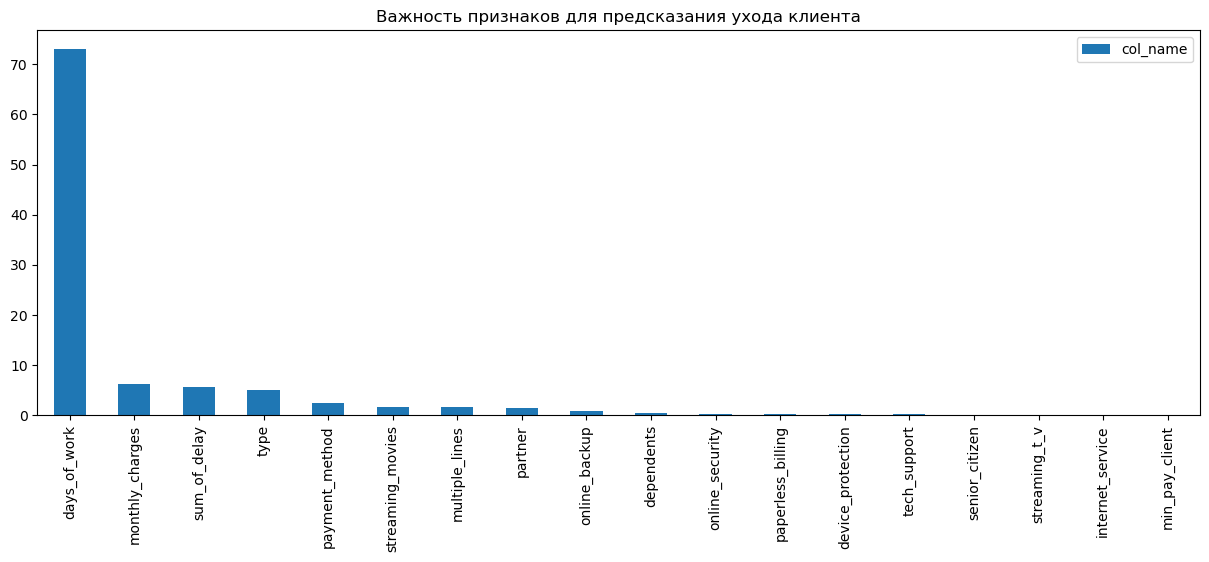

In [77]:
importances.plot(kind='bar', figsize=(15,5)).set(title = 'Важность признаков для предсказания ухода клиента', label = 'коэф. важности')
plt.show();

Мы сможем видеть на диаграмме выше, какие признаки слабо влияют на отток клиентов, и их можно вообще исключить из обучения, и сделать новую модель, отобрав только самые важные признаки.\
Мы также можем выдать рекомендации бизнесу, изучив влияние признаков на отток, тем самым можно повысить качество определенных услуг.\

**Самый значимый признак для предсказания ухода клиента это время его сотрeдничества с компанией.\
Менее значимыми, но влияющими на уход, являются признаки: сумма ежемесячного платежа, тип договора, сумма просрочек платежей, тип платежа.**

### Проверка лучшей модели на адекватность

Судя по метрике auc_roc 0.92 найденная модель предсказывает лучше, чем случайная модель.

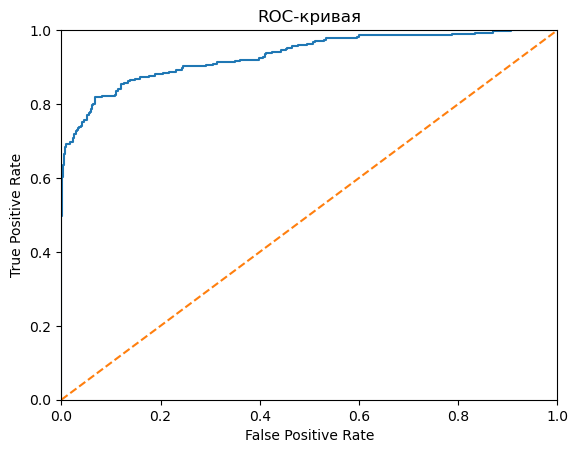

In [78]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])  

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 

plt.title('ROC-кривая')

plt.show()

На графике выше можно визуально подтвердить, что площадь под ROC-кривой найденной модели больше, чем под ROC-кривой случайной модели.

### Матрица ошибок

In [79]:
predictions = model.predict(features_test)
predictions = pd.Series(x=='True' for x in model.predict(features_test))
cm = confusion_matrix(target_test, predictions)
cm

array([[1475,   11],
       [  89,  186]], dtype=int64)

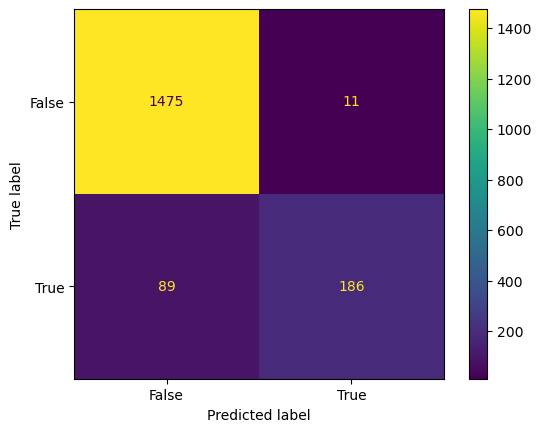

In [80]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot();

**Учитывая диаграмму матрицы ошибок, можно сделать выводы:**

1) Из 1761 клиентов в тестовой выборке 1486 не собирались уходить, из них модель определила 11 клиентов (0,7% из неуходящих и 0,62% из всех) как уходящих - траты на эти промокоды и услуги будут считаться как ошибки модели. 1475 клиетов (99,2% из неуходящих и 83,7% из всех) модель определила правильно, как неуходящих.

2) Из 1761 клиентов в тестовой выборке 275 собирались уходить, из них модель определила 89 клиентов (32,3% из уходящих и 5,05% из всех) как не уходящих - этим клиентам не будут предоставлены промокоды и дополнительные услуги, они по своим причинам уйдут, это будет считаться как ошибка модели. 186 клиентов (67,6% из уходящих и 10,56% из всех) модель определила правильно, как уходящих. Этим клиентам будут высланы промокоды и доп.услуги, что в теории должны задержать клиента от ухода.

## Выводы

Все пункты плана работы были выполнены.
1) Были выделены и созданы основные признаки для обучения моделей: 

Количественные признаки (3 шт.) : ['MonthlyCharges', 'Days_of_work', 'Sum_of_delay']

Качественные признаки (15 шт.) : ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Min_pay_client']

2) Была проведена предобработка этих признаков: работа с пропусками, дубликатами, приведение типов данных признаков в соответствие с их смыслом.

3) Были построены несколько моделей, обучены и подобраны их лучшие гиперпараметры для максимизации метрики:

Итоговая модель, ее гиперпараметры и достигнутое качество:\
Модель: CatBoostClassifier\
Гиперпараметры: 2 - глубина дерева, 400 - количество деревьев, learning_rate - 0.5\
Качество: **метрика roc_auc 0.93**

Значение метрики, согласованное заказчиком доcтигнуто.